In [1]:
from model_utils import *
from sklearn.utils import resample
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    validation_curve,
)
from sklearn import preprocessing

## Import Data
### Data used for preliminary results are downsampled and balanced

In [2]:
# import dataset
test_data = "dataset/test.csv"
df_test = pd.read_csv(test_data, sep=",", index_col="ID_code")

train_data = "dataset/train.csv"
df_train = pd.read_csv(train_data, sep=",", index_col="ID_code")

# Separate majority and minority classes
df2_majority = df_train[df_train["target"] == 0]
df2_minority = df_train[df_train["target"] == 1]
n_samples = df2_minority.target.sum()

df2_majority_downsampled = resample(
   df2_majority, replace=False, n_samples=n_samples, random_state=99
)
df_downsampled = pd.concat([df2_majority_downsampled, df2_minority])
X_dn = df_downsampled.drop(["target"], axis=1)
y_dn = df_downsampled["target"]

# calculatig the z-score normalization using sklearn
std_scale = preprocessing.StandardScaler().fit(df_train.drop(["target"], axis=1).values)
X_dn_norm = std_scale.transform(X_dn)

#use all downsamples samples (40 000)
X_train, X_test, y_train, y_test = train_test_split(X_dn_norm, y_dn, test_size=0.2, random_state=101)

#reduce size of for cbomputationally intensive algorithms
X_trainsmall, _, y_trainsmall, _ = train_test_split(X_train, y_train, test_size=0.8756096, random_state=101)

## Create Models using default Parameters

In [3]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_params = {
    'C': 0.00010494583820459354, 
#    'C': 1, 
    'solver': 'saga'
}
clf_logreg = LogisticRegression(random_state=111, penalty='l2', **logreg_params)

In [4]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

NB_params = {
    'var_smoothing': 7.453943540948982e-11
}
clf_NB = GaussianNB(**NB_params)

In [5]:
# XGBoost
import xgboost as xgb

xgb_params = {
    'colsample_bylevel': 0.01, 
    'colsample_bytree': 1.0,
    'gamma': 0.49999999999999994,
    'max_delta_step': 0,
    'max_depth': 8,
    'min_child_weight': 19,
    'reg_alpha': 1.0,
    'reg_lambda': 1000.0,
    'scale_pos_weight': 0.3237122916966163,
    'subsample': 1.0,
}

clf_xgb = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        learning_rate=0.1,
        silent=1,
        early_stopping=200,
        n_estimators=8000,
        tree_method="approx",
        n_jobs=-1,
        **xgb_params,
    )


In [6]:
# LightGBM
import lightgbm as lgb

lgb_params = {
    'colsample_bylevel': 0.5447321073292221,
    'colsample_bytree': 0.689559548843798,
    'gamma': 0.01,
    'max_bin': 426,
    'max_delta_step': 13,
    'max_depth': 12,
    'min_child_samples': 22,
    'min_child_weight': 20,
    'reg_alpha': 0.7966900476208586,
    'reg_lambda': 0.05905416598434505,
    'scale_pos_weight': 0.23497655517415514,
    'subsample': 0.9183687205758093,
    'subsample_for_bin': 492045,
    'subsample_freq': 3,
}

clf_lgb = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        tree_method='approx',
        learning_rate = 0.1,
        silent=1,
        n_estimators= 7000,
        verbose=0,
        n_jobs=-1,
        **lgb_params,
    )


### EXPERIMENT
#### Will upsampling improve performance of the models using the prelimiary parameters

## Train and Benchmark All Models

### Logistic Regression

In [7]:
# Benchmark Logistic Regression

model_logreg = clf_logreg.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


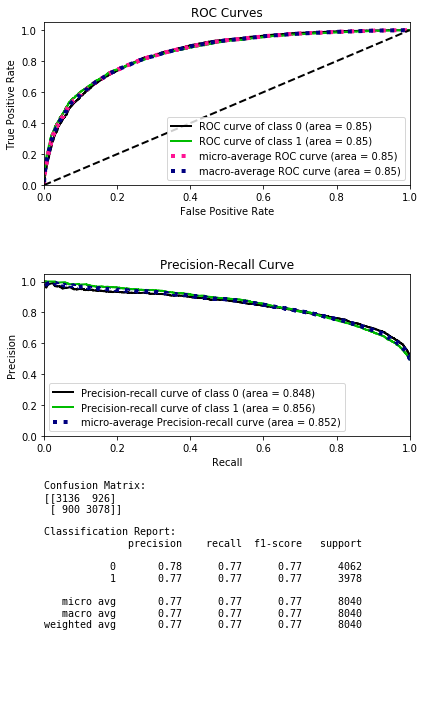

In [8]:
stats_fig, report = benchmark_model_performance(model_logreg, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-logisticregression.png'), dpi=300, format='png')
stats_fig.show()

### Naive Bayes

In [9]:
# Benchmark Logistic Regression

model_NB = clf_NB.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


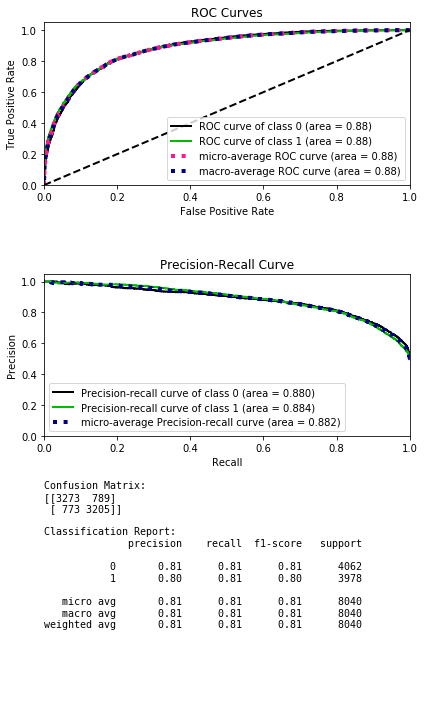

In [10]:
stats_fig, report = benchmark_model_performance(model_NB, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-naivebayes.png'), dpi=300, format='png')
stats_fig.show()

### XGBoost

In [11]:
# Benchmark Logistic Regression

model_xgb = clf_NB.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


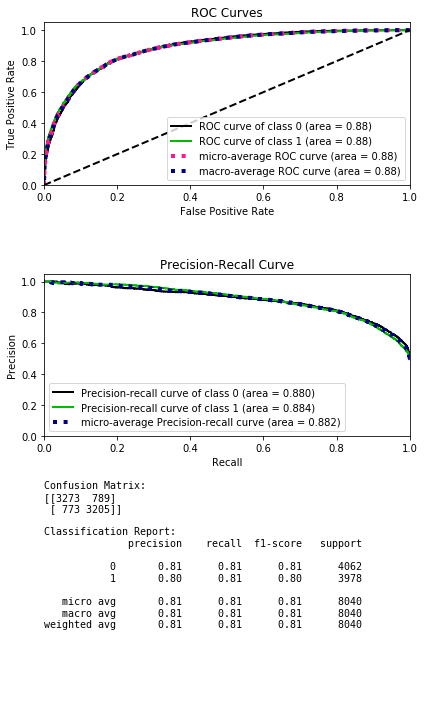

In [12]:
stats_fig, report = benchmark_model_performance(model_xgb, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-xgb.png'), dpi=300, format='png')
stats_fig.show()

### Light GBM

In [13]:
# Benchmark Logistic Regression

model_lgb = clf_lgb.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


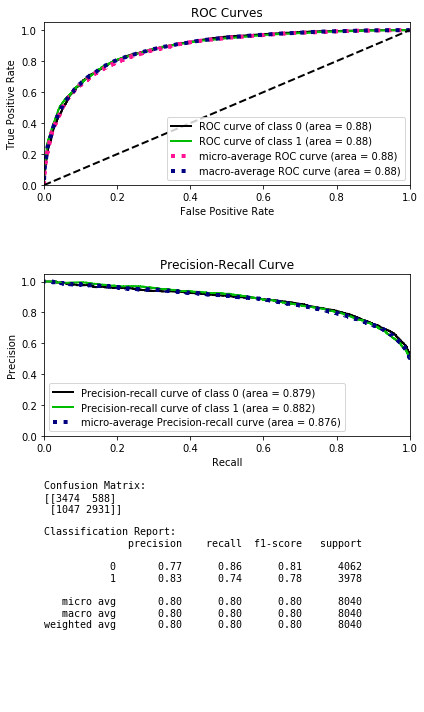

In [14]:
stats_fig, report = benchmark_model_performance(model_lgb, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-lgb.png'), dpi=300, format='png')
stats_fig.show()

### EXPERIMENT
#### ensembling the 4 models

In [33]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
)

pred_y1 = model_logreg.predict_proba(X_test)
pred_y2 = model_NB.predict_proba(X_test)
pred_y3 = model_xgb.predict_proba(X_test)
pred_y4 = model_lgb.predict_proba(X_test)

prediction = (pred_y1 + pred_y2 + pred_y3 + pred_y4) / 4

In [34]:
prediction = prediction.round()[:,1]
prediction

array([1., 0., 1., ..., 1., 1., 0.])

In [35]:
report = 'Confusion Matrix:\n' + str(confusion_matrix(y_test, prediction))
report = report + '\n\nClassification Report:\n' + str(classification_report(y_test, prediction))

print(report)

Confusion Matrix:
[[3367  695]
 [ 873 3105]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4062
           1       0.82      0.78      0.80      3978

   micro avg       0.80      0.80      0.80      8040
   macro avg       0.81      0.80      0.80      8040
weighted avg       0.81      0.80      0.80      8040



In [68]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
)
import numpy as np
from statistics import mode

pred_y1 = model_logreg.predict(X_test).round()
pred_y2 = model_NB.predict(X_test).round()
pred_y3 = model_xgb.predict(X_test).round()
pred_y4 = model_lgb.predict(X_test).round()

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, mode([pred_y2[i], pred_y3[i], pred_y4[i]]))

In [69]:
X_test.shape

(8040, 200)

In [70]:
final_pred.shape

(8040,)

In [71]:
report = 'Confusion Matrix:\n' + str(confusion_matrix(y_test, final_pred.round()))
report = report + '\n\nClassification Report:\n' + str(classification_report(y_test, final_pred.round()))

print(report)

Confusion Matrix:
[[3273  789]
 [ 773 3205]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4062
           1       0.80      0.81      0.80      3978

   micro avg       0.81      0.81      0.81      8040
   macro avg       0.81      0.81      0.81      8040
weighted avg       0.81      0.81      0.81      8040

